In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('config.json') as config_file:
    config = json.load(config_file)

model_number = 2

In [3]:
IN_SHAPE, DELTA = 0, 0
if model_number == 1: 
    IN_SHAPE = 75
    DELTA = config["resolution"]
elif model_number == 2: 
    IN_SHAPE = 64
    DELTA = config["resolution_2"]
else: 
    IN_SHAPE = 64
    DELTA = config["resolution_3"]

MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]
OUT_SHAPE = IN_SHAPE*N_MAG*MAGNIFICATION

alpha_t_scaling = config["alpha_t_scaling_2"]

alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff_1.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp_1.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

def alpha_delta_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff_2.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp_2.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

def variation_density_loss(alpha):
        diff_x = torch.abs(alpha[:, :, 1:, :] - alpha[:, :, :-1, :])
        diff_y = torch.abs(alpha[:, :, :, 1:] - alpha[:, :, :, :-1])
        return torch.sum(diff_x)/(diff_x.shape[2]*diff_x.shape[3]) + torch.sum(diff_y)/(diff_y.shape[2]*diff_y.shape[3])

In [5]:
dataset_no_sub = data.LensingDataset('../Simulations/test/data_model_%d/'%model_number,['no_sub'],5000)
dataset_axion = data.LensingDataset('../Simulations/test/data_model_%d/'%model_number,['axion'],5000)
dataset_cdm = data.LensingDataset('../Simulations/test/data_model_%d/'%model_number,['cdm'],5000)

HR_no_sub = data.LensingDataset('../Simulations/test/data_model_%d/'%model_number,['no_sub_HR'],5000)
HR_axion = data.LensingDataset('../Simulations/test/data_model_%d/'%model_number,['axion_HR'],5000)
HR_cdm = data.LensingDataset('../Simulations/test/data_model_%d/'%model_number,['cdm_HR'],5000)

In [6]:
alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, out_channels=1, latent_channel_count=config["latent_channels"]).to(device)
alpha_delta_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, out_channels=1, latent_channel_count=config["latent_channels"]).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25])
alpha_model.load_state_dict(torch.load('Weights_%d.pt'%(model_number), weights_only=True))
alpha_delta_model.load_state_dict(torch.load('Delta_%d.pt'%(model_number), weights_only=True))

<All keys matched successfully>

In [7]:
def give_image(dataset, HR_dataset, alpha_model, length, i=None, plot=False, history = None):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i][0].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha_r = alpha_model(LR.to(device)).detach()
    alpha_r = alpha_scaling(alpha_r)
    alpha_delta = alpha_delta_model(LR.to(device)).detach()
    alpha_delta = alpha_delta_scaling(alpha_delta)
    sersic_profile, LR, source_profile = lens_loss.get_sample((alpha_r+alpha_delta).to(device), LR.to(device), plot)

    if plot:
        plot, axes = plt.subplots(1,4)
        plot.set_size_inches(20,5)
        axes[0].imshow(Image.fromarray(sersic_profile.detach().cpu().numpy()[0]*255))
        axes[1].imshow(Image.fromarray(LR.detach().cpu().numpy()[0]*255))
        axes[2].imshow(Image.fromarray(source_profile.detach().cpu().numpy()[0]*255))
        axes[3].imshow(Image.fromarray(HR_dataset[i][0].detach().cpu().numpy()[0]*255))
        axes[0].set_title('Lensed')
        axes[1].set_title('LR')
        axes[2].set_title('Source')
        axes[3].set_title('HR')

    return sersic_profile[0].to(device), LR, source_profile, HR_dataset[i][0].to(device)

(tensor([[3.6443e-12, 5.4130e-12, 7.6895e-12,  ..., 1.7722e-10, 1.4040e-10,
          1.1084e-10],
         [5.1935e-12, 7.4353e-12, 1.0304e-11,  ..., 2.2917e-10, 1.8126e-10,
          1.4290e-10],
         [7.1067e-12, 9.9148e-12, 1.3551e-11,  ..., 2.9451e-10, 2.3275e-10,
          1.8319e-10],
         ...,
         [1.4692e-12, 2.5923e-12, 4.0349e-12,  ..., 1.0525e-10, 8.3559e-11,
          6.5995e-11],
         [6.5345e-13, 1.5430e-12, 2.6709e-12,  ..., 8.0990e-11, 6.4262e-11,
          5.0755e-11],
         [0.0000e+00, 6.9575e-13, 1.5841e-12,  ..., 6.1816e-11, 4.9052e-11,
          3.8723e-11]], device='cuda:0'),
 tensor([[[0.0118, 0.0165, 0.0118,  ..., 0.0112, 0.0110, 0.0105],
          [0.0117, 0.0059, 0.0121,  ..., 0.0121, 0.0130, 0.0145],
          [0.0074, 0.0093, 0.0086,  ..., 0.0135, 0.0098, 0.0129],
          ...,
          [0.0109, 0.0133, 0.0085,  ..., 0.0174, 0.0100, 0.0097],
          [0.0074, 0.0120, 0.0112,  ..., 0.0095, 0.0155, 0.0113],
          [0.0107, 0.0123, 0

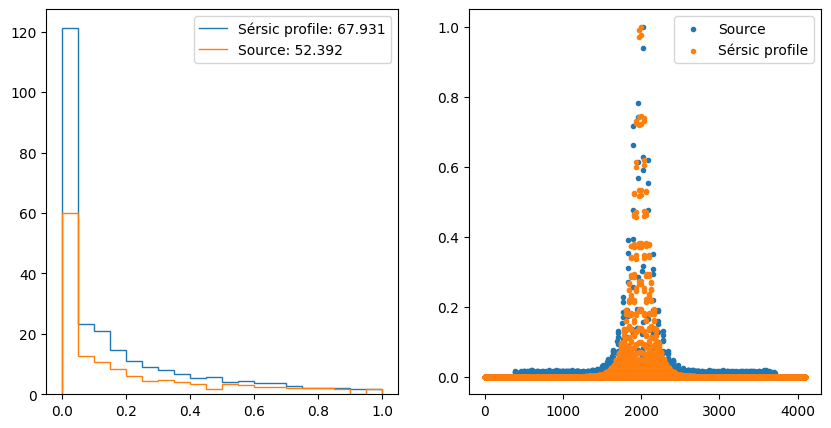

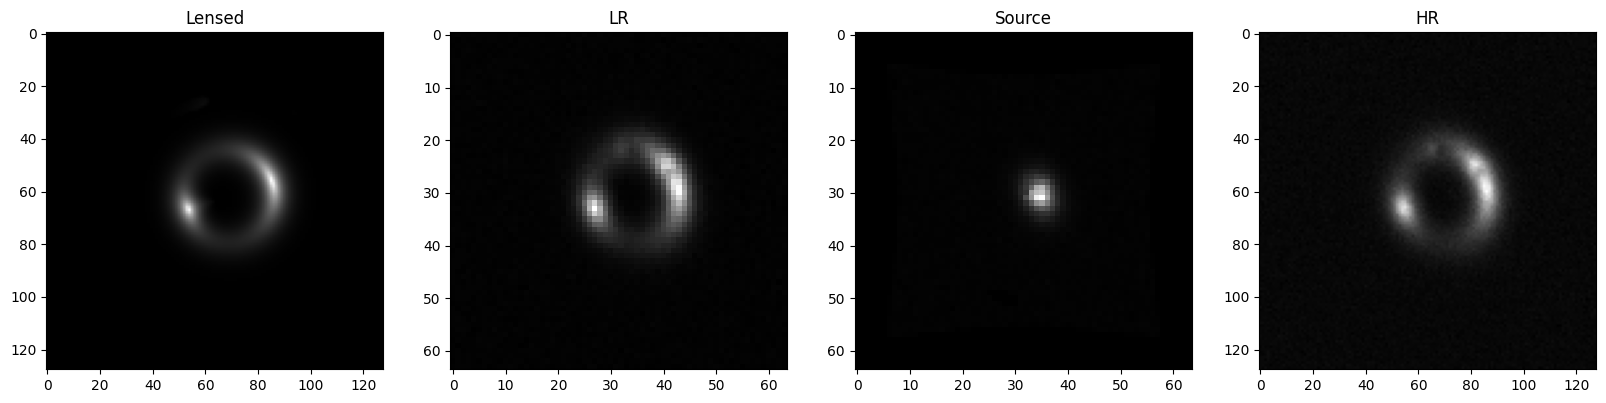

In [11]:
give_image(dataset_cdm, HR_cdm, alpha_model, len(dataset_cdm), plot=True)

In [9]:
def PSNR(mse): 
    """
    Computes the peak-signal to noise ratio

    :param mse: MSE to calculate from
    :return: PSNR value
    """ 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr

from skimage.metrics import structural_similarity
history_no_sub = {'loss':[],'SSIM':[], 'PSNR':[], 'vdl':[]}
history_axion = {'loss':[],'SSIM':[], 'PSNR':[], 'vdl':[]}
history_cdm = {'loss':[],'SSIM':[], 'PSNR':[], 'vdl':[]}

In [10]:
alpha_model.eval()
alpha_delta_model.eval()
for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating CDM sub-structure images"):
    image, _, __, HR = give_image(dataset_cdm, HR_cdm, alpha_model, len(dataset_no_sub), i, False, history_cdm)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_cdm['loss'].append(float(loss))
    image, HR = image.cpu().numpy()[0], HR.cpu().numpy()[0]
    history_cdm['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_cdm['PSNR'].append(PSNR(float(loss)))

for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating no sub-structure images"):
    image, _, __, HR = give_image(dataset_no_sub, HR_no_sub, alpha_model, len(dataset_no_sub), i, False, history_no_sub)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_no_sub['loss'].append(float(loss))
    image, HR = image.cpu().numpy()[0], HR.cpu().numpy()[0]
    history_no_sub['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_no_sub['PSNR'].append(PSNR(float(loss)))

for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating axion DM sub-structure images"):
    image, _, __, HR = give_image(dataset_axion, HR_axion, alpha_model, len(dataset_no_sub), i, False, history_axion)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_axion['loss'].append(float(loss))
    image, HR = image.cpu().numpy()[0], HR.cpu().numpy()[0]
    history_axion['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_axion['PSNR'].append(PSNR(float(loss)))

Evaluating axion DM sub-structure images: 100%|██████████| 5000/5000 [00:41<00:00, 121.53it/s]


In [11]:
print(f"no_sub: Evaluation completed with \nMSE: {np.mean(history_no_sub['loss'])} ({np.std(history_no_sub['loss'])})\nSSIM: {np.mean(history_no_sub['SSIM'])} ({np.std(history_no_sub['SSIM'])})\nPSNR:  {np.mean(history_no_sub['PSNR'])} ({np.std(history_no_sub['PSNR'])})")
print(f"axion: Evaluation completed with \nMSE: {np.mean(history_axion['loss'])} ({np.std(history_axion['loss'])})\nSSIM: {np.mean(history_axion['SSIM'])} ({np.std(history_axion['SSIM'])})\nPSNR:  {np.mean(history_axion['PSNR'])} ({np.std(history_axion['PSNR'])})")
print(f"cdm: Evaluation completed with \nMSE: {np.mean(history_cdm['loss'])} ({np.std(history_cdm['loss'])})\nSSIM: {np.mean(history_cdm['SSIM'])} ({np.std(history_cdm['SSIM'])})\nPSNR:  {np.mean(history_cdm['PSNR'])} ({np.std(history_cdm['PSNR'])})")

no_sub: Evaluation completed with 
MSE: 0.0015903131910929306 (0.0010739030294022614)
SSIM: 0.8199770432937777 (0.024324742849800338)
PSNR:  28.844712804774858 (2.749644041973447)
axion: Evaluation completed with 
MSE: 0.0016332293194122635 (0.0012541497415197301)
SSIM: 0.8138670824516354 (0.02873770799919959)
PSNR:  28.881102395029647 (2.930790934221998)
cdm: Evaluation completed with 
MSE: 0.0016317650098380226 (0.0011319932254637568)
SSIM: 0.812443862503437 (0.02647405830967857)
PSNR:  28.738807655422058 (2.727506325931471)


In [12]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Sub-structure","MSE","SSIM","PSNR","VDL"]
table.add_row(["No_substructure","%0.6f"%np.mean(history_no_sub['loss']),"%0.3f"%np.mean(history_no_sub['SSIM']),"%0.3f"%np.mean(history_no_sub['PSNR']), "%0.3f (%0.3f)"%(np.mean(history_no_sub['vdl']),np.std(history_no_sub['vdl']))])
table.add_row(["Axion (vortex)","%0.6f"%np.mean(history_axion['loss']),"%0.3f"%np.mean(history_axion['SSIM']),"%0.3f"%np.mean(history_axion['PSNR']), "%0.3f (%0.3f)"%(np.mean(history_axion['vdl']),np.std(history_axion['vdl']))])
table.add_row(["CDM (sub-halos)","%0.6f"%np.mean(history_cdm['loss']),"%0.3f"%np.mean(history_cdm['SSIM']),"%0.3f"%np.mean(history_cdm['PSNR']), "%0.3f (%0.3f)"%(np.mean(history_cdm['vdl']),np.std(history_cdm['vdl']))])
print(table)

+-----------------+----------+-------+--------+---------------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |
+-----------------+----------+-------+--------+---------------+
| No_substructure | 0.001590 | 0.820 | 28.845 | 0.001 (0.001) |
|  Axion (vortex) | 0.001633 | 0.814 | 28.881 | 0.001 (0.001) |
| CDM (sub-halos) | 0.001632 | 0.812 | 28.739 | 0.001 (0.001) |
+-----------------+----------+-------+--------+---------------+


In [13]:
"""
Model 1:
+-----------------+----------+-------+--------+---------------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |
+-----------------+----------+-------+--------+---------------+
| No_substructure | 0.003584 | 0.761 | 25.262 | 0.000 (0.000) |
|  Axion (vortex) | 0.002909 | 0.766 | 25.881 | 0.000 (0.000) |
| CDM (sub-halos) | 0.003259 | 0.755 | 25.486 | 0.000 (0.000) |
+-----------------+----------+-------+--------+---------------+

Model 2:
+-----------------+----------+-------+--------+---------------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |
+-----------------+----------+-------+--------+---------------+
| No_substructure | 0.002925 | 0.223 | 25.580 | 0.001 (0.001) |
|  Axion (vortex) | 0.002909 | 0.221 | 25.640 | 0.001 (0.001) |
| CDM (sub-halos) | 0.003016 | 0.220 | 25.462 | 0.001 (0.001) |
+-----------------+----------+-------+--------+---------------+

Model 3:
+-----------------+----------+-------+--------+---------------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |
+-----------------+----------+-------+--------+---------------+
| No_substructure | 0.001590 | 0.820 | 28.845 | 0.001 (0.001) |
|  Axion (vortex) | 0.001633 | 0.814 | 28.881 | 0.001 (0.001) |
| CDM (sub-halos) | 0.001632 | 0.812 | 28.739 | 0.001 (0.001) |
+-----------------+----------+-------+--------+---------------+
"""

'\nModel 1:\n+-----------------+----------+-------+--------+---------------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |\n+-----------------+----------+-------+--------+---------------+\n| No_substructure | 0.003584 | 0.761 | 25.262 | 0.000 (0.000) |\n|  Axion (vortex) | 0.002909 | 0.766 | 25.881 | 0.000 (0.000) |\n| CDM (sub-halos) | 0.003259 | 0.755 | 25.486 | 0.000 (0.000) |\n+-----------------+----------+-------+--------+---------------+\n\nModel 2:\n+-----------------+----------+-------+--------+---------------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |\n+-----------------+----------+-------+--------+---------------+\n| No_substructure | 0.002925 | 0.223 | 25.580 | 0.001 (0.001) |\n|  Axion (vortex) | 0.002909 | 0.221 | 25.640 | 0.001 (0.001) |\n| CDM (sub-halos) | 0.003016 | 0.220 | 25.462 | 0.001 (0.001) |\n+-----------------+----------+-------+--------+---------------+\n\nModel 3:\n+-----------------+----------+-------+--------+\n|  S